In [39]:
"""
Created on Mon Mar 25 18:00:45 2019

@author: luisgranados
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

house_source_data = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")

# Store the label for the training set. 
house_labels = house_source_data['SalePrice'].copy().drop([691, 1182, 1169, 803, 897, 898, 185, 495, 968,
                                                      705, 642, 769, 798, 1046, 440, 190, 608, 1268,
                                                      1353, 426, 1423])

# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Stage the ratings for the mapper function.
# Remember, these are ordinal features.
qual_rating_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond', 'PoolQC']

qual_ordinal_ratings = [
        ('Ex',5), 
        ('Gd',4), 
        ('TA',3), 
        ('Fa',2), 
        ('Po',1), 
        ('NA',0)
    ]

# Exposure features need own mapping.
exposure_rating_feature = ['BsmtExposure']
exposure_ordinal_ratings = [
        ('Gd',4), 
        ('Av',3), 
        ('Mn',2), 
        ('No',1), 
        ('NA',0)
    ]

electrical_rating_feature = ['Electrical']
electrical_ordinal_ratings = [
        ('SBrkr',5),
        ('FuseA',4),
        ('FuseF',3),
        ('FuseP',2),
        ('Mix',1)
    ]

functional_rating_feature = ['Functional']
functional_ordinal_ratings = [
        ('Typ',7), 
        ('Min1',6), 
        ('Min2',5), 
        ('Mod',4), 
        ('Maj1',3),
        ('Maj2',2),
        ('Sev',1),
        ('Sal',0)
    ]

# Finish ratings
bsmt_finish_rating_features = ['BsmtFinType1', 'BsmtFinType2']
bsmtfin_ordinal_ratings = [
        ('GLQ',6), 
        ('ALQ',5), 
        ('BLQ',4), 
        ('Rec',3), 
        ('LwQ',2),
        ('Unf',1),
        ('NA',0)
    ]

grg_finish_rating_feature = ['GarageFinish']
grgfin_ordinal_ratings = [
        ('Fin',3), 
        ('RFn',2), 
        ('Unf',1), 
        ('NA',0)
    ]

paved_rating_feature = ['PavedDrive']
paved_ordinal_ratings = [
        ('Y',2), 
        ('P',1), 
        ('N',0)
    ]

fence_rating_feature = ['Fence']
fence_ordinal_ratings = [
        ('GdPrv',4),
        ('MnPrv',3),
        ('GdWo',2), 
        ('MnWw',1),
        ('NA',0)
    ]

alley_rating_feature = ['Alley']
alley_ordinal_ratings = [
        ('Pave',2),
        ('Grvl',1),
        ('NA',0)
    ]

utilities_rating_feature = ['Utilities']
utilities_ordinal_ratings = [
        ('AllPub',3),
        ('NoSewr',2),
        ('NoSeWa',1),
        ('ELO', 0)
    ]

# Select categorical features to one-hot-encode.
categorial_onehot_features = ['MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'
    ]

selected_categorical_onehot = [
    'MSZoning',
    'Street',
    #'LandContour',
    #'LotConfig',
    #'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    #'BldgType', # might still keep this one
    'HouseStyle',
    'RoofStyle',
    #'RoofMatl',
    'Exterior1st',
    #'Exterior2nd', #might keep this
    #'MasVnrType',
    #'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'      
]

# Use this function for generating new ones. I can't generalize this part 
# because of all the potentially different ways to create each feature.
# but this will allow me to do the same generation for the test set.
def generator(dataframe):
    """Generate new features."""
    new_dataframe = dataframe.copy()
    
    #new_dataframe['LotArea_sqrd'] = new_dataframe['LotArea']**2
    
    new_dataframe['yard_size'] = new_dataframe['LotArea'] - (new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['yard_size_sqrd'] = new_dataframe['yard_size']**2
    
    new_dataframe['yard_size_cubed'] = new_dataframe['yard_size']**3
    
    new_dataframe['YearBuilt_sqrd'] = new_dataframe['YearBuilt']**2
    
    new_dataframe['YearBuilt_cubed'] = new_dataframe['YearBuilt']**3
    
    new_dataframe['total_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['total_house_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'])
    
    new_dataframe['total_bathrooms'] = (new_dataframe['FullBath'] + (0.5 * new_dataframe['HalfBath']) +
                               new_dataframe['BsmtFullBath'] + (0.5 * new_dataframe['BsmtHalfBath']))
    
    #new_dataframe['total_sqft_sqrd'] = new_dataframe['total_sqft']**2
    
    #new_dataframe['total_sqft_cubed'] = new_dataframe['total_sqft']**3
    
    new_dataframe['liv_area_interaction'] = new_dataframe['GrLivArea'] * new_dataframe['total_sqft']
    
    new_dataframe['liv_area_interaction_sqrd'] = new_dataframe['liv_area_interaction']**2
    
    #new_dataframe['liv_area_interaction_cubed'] = new_dataframe['liv_area_interaction']**3
    
    new_dataframe['housesqft_qual_inter'] = new_dataframe['total_sqft'] * new_dataframe['OverallQual']
    
    new_dataframe['OverallCond_Qual_inter'] = new_dataframe['OverallCond'] * new_dataframe['OverallQual']
    
    new_dataframe['Garage_sqft_sqrd'] = new_dataframe['GarageArea']**2
    
    #new_dataframe['Garage_sqft_cubed'] = new_dataframe['GarageArea']**3
    
    new_dataframe['Garage_CQ_inter'] = (new_dataframe['GarageQual'] * new_dataframe['GarageCond'] *
                                       new_dataframe['GarageCars'] * new_dataframe['GarageArea'])
    
    new_dataframe['Outdoor_lounging'] = (new_dataframe['EnclosedPorch'] + new_dataframe['OpenPorchSF'] * 
                                         new_dataframe['WoodDeckSF'] + new_dataframe['3SsnPorch'] +
                                         new_dataframe['ScreenPorch'])
    
    #new_dataframe['Outdoor_lounging_sqrd'] = new_dataframe['Outdoor_lounging']**2
    
    #new_dataframe['Outdoor_lounging_cubed'] = new_dataframe['Outdoor_lounging']**3
    
    new_dataframe['outdoor_inter'] = new_dataframe['Outdoor_lounging'] * new_dataframe['yard_size']
    
    #new_dataframe['RoomQual_inter'] = new_dataframe['TotRmsAbvGrd'] * new_dataframe['OverallQual']
    
    #new_dataframe['BedroomAbvGr_sqrd'] = new_dataframe['BedroomAbvGr']**2
    
    #new_dataframe['BedroomAbvGr_cubed'] = new_dataframe['BedroomAbvGr']**3
    
    new_dataframe['Exter_inter'] = new_dataframe['ExterCond'] * new_dataframe['ExterQual'] * new_dataframe['MasVnrArea']
 
    new_dataframe['KitchenAbvGr_sqrd'] = new_dataframe['KitchenAbvGr']**2
    
    new_dataframe['kitchen_inter'] = new_dataframe['KitchenAbvGr'] * new_dataframe['KitchenQual']
    
    new_dataframe['bsmt_qual_inter'] = (new_dataframe['BsmtQual'] * new_dataframe['BsmtCond'] * 
                                        new_dataframe['TotalBsmtSF'])

    new_dataframe['BsmtQual_sqrd'] = new_dataframe['BsmtQual']**2
    
    new_dataframe['BsmtQual_cubed'] = new_dataframe['BsmtQual']**3
    
    new_dataframe['BsmtUnfSF_sqrd'] = new_dataframe['BsmtUnfSF']**2
    
    new_dataframe['BsmtUnfSF_cubed'] = new_dataframe['BsmtUnfSF']**3
    
    new_dataframe['BsmtFinSF2_sqrd'] = new_dataframe['BsmtFinSF2']**2
    
    new_dataframe['BsmtFinSF2_cubed'] = new_dataframe['BsmtFinSF2']**3
    
    #new_dataframe['bath_inter'] = (new_dataframe['OverallCond'] * new_dataframe['FullBath'] *
    #                              new_dataframe['OverallQual'])
    
    new_dataframe['fireplace_inter'] = new_dataframe['Fireplaces'] * new_dataframe['FireplaceQu']
    
    return new_dataframe

def mapper(data_in, features, ratings):
    """Map ordinal ratings to numeric ranking."""
    counter = 0
    for feature in features:
        ordinal_mapping = [{
            "col":feature,    
            "mapping": ratings},
        ]

        encoder = ce.OrdinalEncoder(mapping = ordinal_mapping, 
                                    return_df = True, cols = feature)
        if counter == 0:
            df_train = encoder.fit_transform(data_in.copy())
        else:
            df_train = encoder.fit_transform(df_train)
        counter += 1
    return df_train

def data_staging(data_in):
    """Create preliminary training set."""
    data_frame = data_in.copy()
    
    # Fill in the null values with None.
    category_data = data_frame.copy().select_dtypes(exclude='number').fillna(value='None')

    # Fill in null values with 0.
    numeric_data = (data_frame
             .loc[:, data_frame.copy().columns != 'LotFrontage']
             .select_dtypes(include='number')
             .fillna(value=0)
            )

    # Re-merge the two datasets. Drop label and unneeded features.
    data_in_cleaned = (category_data
                         .merge(numeric_data, how='outer',
                                left_index=True, right_index=True)
                         .drop(columns=['SalePrice', 'MiscFeature', 'Id'], errors='ignore')
                        )
    data_in_cleaned = pd.concat([data_in_cleaned, data_in['LotFrontage']], axis=1)
    
    data_in_cleaned = mapper(data_in_cleaned, qual_rating_features, qual_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, bsmt_finish_rating_features, bsmtfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, exposure_rating_feature, exposure_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, electrical_rating_feature, electrical_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, functional_rating_feature, functional_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, grg_finish_rating_feature, grgfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, paved_rating_feature, paved_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, fence_rating_feature, fence_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, alley_rating_feature, alley_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, utilities_rating_feature, utilities_ordinal_ratings)
    
    # Generate new features.
    data_in_cleaned = generator(data_in_cleaned)
    
    return data_in_cleaned

# Create the preliminary training set. This is for analysis.
# numeric attributes get pulled from here.

features_to_drop = ['MoSold', 'YrSold', 'BsmtFinType2', '3SsnPorch', 'BsmtFinSF2',
                   'BsmtHalfBath', 'PoolArea', 'ExterCond', 'MiscVal',
                   'LowQualFinSF', 'OverallCond', 'Alley', 'EnclosedPorch',
                   'KitchenAbvGr', 'Fence', 'Functional', 'ScreenPorch', 'PoolQC',
                   'BedroomAbvGr', 'BsmtCond', 'BsmtUnfSF', 'Utilities',
                   'GarageYrBlt']

house_train_staging = data_staging(house_source_data.copy()).drop(columns=features_to_drop).drop([691, 1182, 1169, 803, 897, 898, 185, 495, 968,
                                                      705, 642, 769, 798, 1046, 440, 190, 608, 1268,
                                                      1353, 426, 1423])

house_test_staging = data_staging(house_test.copy()).drop(columns=features_to_drop)

# Store all the numeric type column names for DataFrameSelector(). 
# MSSubClass gets encoded, so it gets droped from the numeric list of features to process.
numeric_features = list(house_train_staging.select_dtypes(include='number').columns)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), selected_categorical_onehot)
    ])

house_train = preprocessor.fit_transform(house_train_staging.copy())
house_test_data = preprocessor.transform(house_test_staging.copy())

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

seed = 42
np.random.seed(seed)

In [1177]:
house_source_data["SalePrice"]

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [847]:
house_source_data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

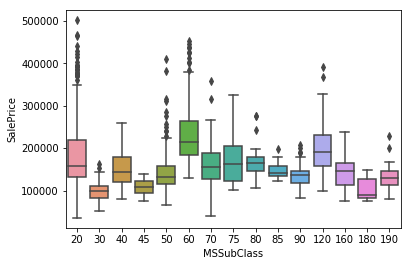

In [1012]:
sns.boxplot(house_train_staging['MSSubClass'], house_source_data['SalePrice'])

In [864]:
house_source_data[['MSSubClass', 'SalePrice']].loc[house_source_data['MSSubClass']==75].describe()

,MSSubClass,SalePrice
count,299.0,299.000000
mean,60.0,239948.501672
std,0.0,86579.909966
min,60.0,129000.000000
25%,60.0,185000.000000
50%,60.0,215200.000000
75%,60.0,268750.000000
max,60.0,755000.000000


In [1018]:
house_train_staging[['SalePrice']].loc[(house_train_staging['MSSubClass'] == 20) & (house_train_staging['SalePrice'] > 400000)]

,SalePrice
178,501837
278,415298
473,440000
496,430000
515,402861
664,423000
1243,465000
1373,466500


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [94]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [13]:
lasso_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('lasso', Lasso(selection='random', random_state=np.random.seed(seed)))])

lasso_param_grid = {'lasso__alpha' : [1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000]}

lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

lasso_grid.fit(house_train_staging.copy(), house_labels)

lasso_grid_pred = lasso_grid.best_estimator_.named_steps['lasso'].predict(house_train)

lasso_rmse = rmsle(house_labels, lasso_grid_pred)

lasso_grid_best = lasso_grid.best_estimator_.named_steps['lasso']

print('Results: {:,.8f} '.format(-lasso_grid.best_score_, lasso_rmse))

Results: 587,682,404.92609322 


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [1151]:
print('Results: {:,.8f} '.format(-lasso_grid.best_score_))

Results: 0.01633323 


In [9]:
lasso_grid.best_params_

{'lasso__alpha': 1400}

In [15]:
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('rig', Ridge(random_state=np.random.seed(seed)))])

ridge_param_grid = {'rig__alpha' : [90, 100, 110, 120, 130, 140, 150, 200, 300, 400, 500]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_grid.fit(house_train_staging.copy(), house_labels)

ridge_grid_pred = ridge_grid.best_estimator_.named_steps['rig'].predict(house_train)

ridge_grid_best = ridge_grid.best_estimator_.named_steps['rig']

print('Results: {:,.8f}'.format(-ridge_grid.best_score_))

Results: 557,276,141.94993544


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
ridge_grid.best_params_

{'rig__alpha': 140}

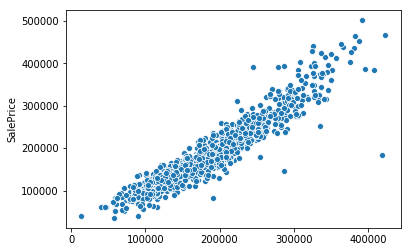

In [17]:
sns.scatterplot(lasso_grid_pred, house_labels)

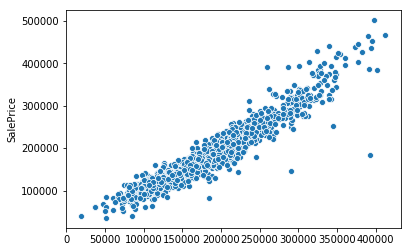

In [14]:
sns.scatterplot(ridge_grid_pred, house_labels)

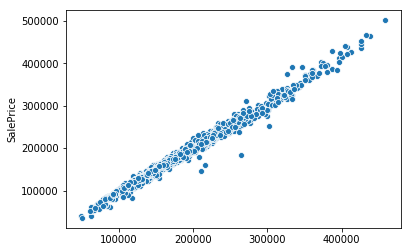

In [1105]:
#fig, ax = plt.subplot()
sns.scatterplot(rf_grid_pred, house_labels)

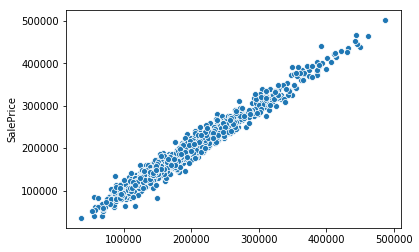

In [1106]:
sns.scatterplot(gbr_grid_pred, house_labels)

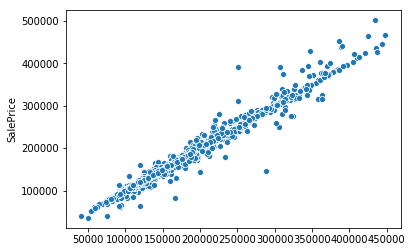

In [1108]:
sns.scatterplot(svm_grid_pred, house_labels)

In [768]:
print('Results: {:8f}'.format(ridge_grid.best_score_))

Results: 0.888014


In [1064]:
elastic_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('elastic', ElasticNet(normalize=False,random_state=np.random.seed(seed)))])

elastic_param_grid = {'elastic__alpha' : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                      'elastic__l1_ratio' : [0.2, 0.3, 0.4, 0.5, 0.85, 0.95, 0.9, 1.0]}

elastic_grid = GridSearchCV(elastic_pipe, param_grid=elastic_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

elastic_grid.fit(house_train_staging.copy(), house_labels)

elastic_grid_pred = elastic_grid.best_estimator_.named_steps['elastic'].predict(house_train)

elastic_rmse = rmsle(house_labels, elastic_grid_pred)

elastic_grid_best = elastic_grid.best_estimator_.named_steps['elastic']

print('Results: {:,.8f} {:8f}'.format(-elastic_grid.best_score_, elastic_rmse))

Results: 556,846,546.02392399 0.125626


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [1035]:
print('Results: {:8f} {:8f}'.format(elastic_grid.best_score_, elastic_rmse))

Results: 0.889347 0.125626


In [1065]:
elastic_grid.best_params_

{'elastic__alpha': 0.2, 'elastic__l1_ratio': 0.4}

In [24]:
from sklearn.svm import SVR

svm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('svm', SVR(gamma='scale'))])

svm_param_grid =  {'svm__C' : [70000, 80000, 90000, 100000, 150000],
                   'svm__epsilon' : [1400, 1500, 2000, 3000, 4000, 5000]}

svm_grid = GridSearchCV(svm_pipe, param_grid=svm_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

svm_grid.fit(house_train_staging.copy(), house_labels)

svm_grid_pred = svm_grid.best_estimator_.named_steps['svm'].predict(house_train)

svm_rmse = rmsle(house_labels, svm_grid_pred)

svm_grid_best = svm_grid.best_estimator_.named_steps['svm']

print('Results: {:,.8f} {:8f}'.format(-svm_grid.best_score_, svm_rmse))

Results: 513,636,359.10026646 0.054028


In [946]:
print('Results: {:8f} {:8f}'.format(svm_grid.best_score_, svm_rmse))

Results: 0.892760 0.048491


In [25]:
svm_grid.best_params_

{'svm__C': 150000, 'svm__epsilon': 1500}

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('rf', RandomForestRegressor(random_state=np.random.seed(seed), n_jobs=-1))])

rf_param_grid =  {'rf__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 20, 25, 30, 35],
                   'rf__n_estimators' : [500, 600, 700, 800, 900, 100],
                   'rf__max_features': ['sqrt']}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

rf_grid.fit(house_train_staging.copy(), house_labels)

rf_grid_pred = rf_grid.best_estimator_.named_steps['rf'].predict(house_train)

rf_rmse = rmsle(house_labels, rf_grid_pred)

rf_grid_best = rf_grid.best_estimator_.named_steps['rf']

print('Results: {:,.8f} {:.8f}'.format(-rf_grid.best_score_, rf_rmse))

/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/extern

Results: 556,733,194.26970935 0.05170079


In [1040]:
print('Results: {:8f}'.format(rf_grid.best_score_))

Results: 0.887510


In [27]:
rf_grid.best_params_

{'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__n_estimators': 600}

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gbr', GradientBoostingRegressor(random_state=np.random.seed(seed)))])

gbr_param_grid = {'gbr__max_depth' : [4, 5, 6],
                  'gbr__n_estimators' : [300, 350, 400],
                  'gbr__learning_rate' : [0.1, 0.2, 0.3],
                  'gbr__subsample' : [0.6]}

gbr_grid = GridSearchCV(gbr_pipe, param_grid=gbr_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

gbr_grid.fit(house_train_staging.copy(), house_labels)

gbr_grid_pred = gbr_grid.best_estimator_.named_steps['gbr'].predict(house_train)

gbr_rmse = rmsle(house_labels, gbr_grid_pred)

gbr_grid_best = gbr_grid.best_estimator_.named_steps['gbr']

print('Results: {:8f} {:8f}'.format(-gbr_grid.best_score_, gbr_rmse))

/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Results: 490323765.700091 0.034561


In [31]:
print('Results: {:8f}'.format(-gbr_grid.best_score_))

Results: 491412035.278939


In [36]:
gbr_grid.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 4,
 'gbr__n_estimators': 300,
 'gbr__subsample': 0.6}

In [ ]:
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[selected_categorical_onehot]).get_feature_names()

all_features = numeric_features + list(encoded_features)

print(len(all_features))

In [ ]:
['OverallCond', 'MasVnrArea','BsmtFinSF2', 'LowQualFinSF',
 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual',
 'BsmtCond', 'HeatingQC', 'KitchenQual', 'Alley', 'BsmtExposure', 'BsmtFinType1',
 'BsmtFinType2', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive',
 'PoolQC', 'Fence', 'Utilities', 'MSSubClass', 'EnclosedPorch']

In [682]:
# Get all the feature importances
importances = list(rf_grid_best.feature_importances_)
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[selected_categorical_onehot]).get_feature_names()

all_features = numeric_features + list(encoded_features)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(all_features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: housesqft_qual_inter Importance: 0.09
Variable: total_sqft           Importance: 0.08
Variable: OverallQual          Importance: 0.06
Variable: liv_area_interaction Importance: 0.06
Variable: liv_area_interaction_sqrd Importance: 0.06
Variable: Garage_CQ_inter      Importance: 0.04
Variable: bsmt_qual_inter      Importance: 0.04
Variable: KitchenQual          Importance: 0.03
Variable: GrLivArea            Importance: 0.03
Variable: ExterQual            Importance: 0.02
Variable: BsmtQual             Importance: 0.02
Variable: YearBuilt            Importance: 0.02
Variable: TotalBsmtSF          Importance: 0.02
Variable: 1stFlrSF             Importance: 0.02
Variable: GarageCars           Importance: 0.02
Variable: YearBuilt_sqrd       Importance: 0.02
Variable: YearBuilt_cubed      Importance: 0.02
Variable: OverallCond_Qual_inter Importance: 0.02
Variable: Garage_sqft_sqrd     Importance: 0.02
Variable: BsmtQual_sqrd        Importance: 0.02
Variable: BsmtQual_cubed       Im

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_logarithmic_error

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=np.shape(house_train)[1], kernel_initializer='normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset

nn_estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=128, verbose=1)

nn_estimator.fit(house_train, house_labels)

results = cross_val_score(nn_estimator, house_train, house_labels, cv=5, n_jobs =1)
score = nn_estimator.score(house_train, house_labels)
rmse = rmsle(house_labels, nn_estimator.predict(house_train))

print("Results: {:.2f}% ({:.2f}%) {:.5f} {:.5f}".format(results.mean()*100, results.std()*100, score, rmse))

In [40]:
def kaggle_submission(estimator, test_set, test_source, label, kaggle_id):
    """
    Create a csv to submit predictions to Kaggle.
    
    estimator: Sci-kit estimator used on training set.
    test_set: The test set.
    label: The name of the label; must be a string.
    test_source: The original training set, which contains the Id column.
    kaggle_id: The id column from the test set. 
    """
    predictions = estimator.predict(test_set)
    predictions = pd.DataFrame(predictions, columns=[label])
    submission = pd.DataFrame(test_source[kaggle_id])
    submission[label] = predictions[label]
    return submission

predictions = kaggle_submission(gbr_grid_best, house_test_data, 
                                house_test, 'SalePrice', 'Id')

predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [ ]:
predictions.to_csv('gbr_reduced_with_featuring_submission.csv', index=False)